# Image Restoration

In [29]:
import torch
import matplotlib.pyplot as plt
import skimage
import einops
import torchvision.transforms.v2 as T

from skimage.color import label2rgb
from skimage.feature import canny
from skimage.feature import corner_harris
from skimage.feature import Cascade
from skimage.measure import find_contours
from skimage.restoration import inpaint
from skimage.segmentation import slic
from torchvision import io

In [30]:
img = io.decode_image("../assets/images/sameer.jpg")
img = img.permute(1, 2, 0)

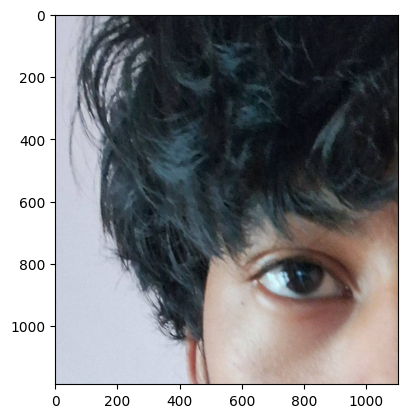

In [31]:
plt.imshow(img)

## Masking

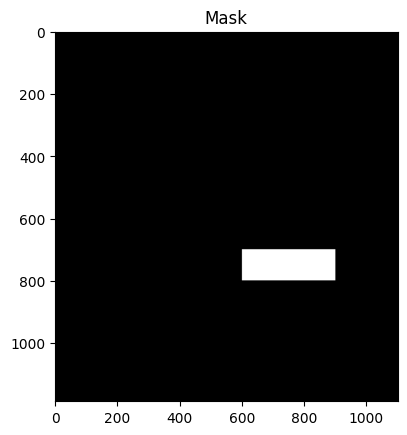

In [32]:
mask = torch.zeros(img.shape[:-1], dtype=torch.uint8)
mask[700:800, 600:900] = 1

plt.title("Mask")
plt.imshow(mask, cmap="gray")

## Biharmonic Restoration

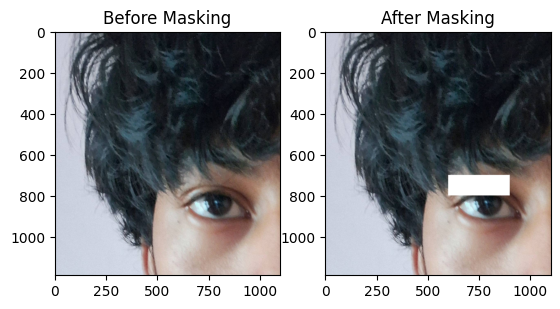

In [33]:
damaged_img = img.clone()

plt.subplot(1, 2, 1)
plt.title("Before Masking")
plt.imshow(damaged_img, cmap="gray")

damaged_img[mask==1] = 255
plt.subplot(1, 2, 2)
plt.title("After Masking")
plt.imshow(damaged_img, cmap="gray")

In [34]:
mask_3 = einops.repeat(
    mask, "w h -> w h c", c=3
)

In [35]:
mask_3.shape

torch.Size([1187, 1101, 3])

In [36]:
damaged_img.shape

torch.Size([1187, 1101, 3])

In [37]:
restored_biharmonic = inpaint.inpaint_biharmonic(damaged_img.numpy(), mask_3.numpy())

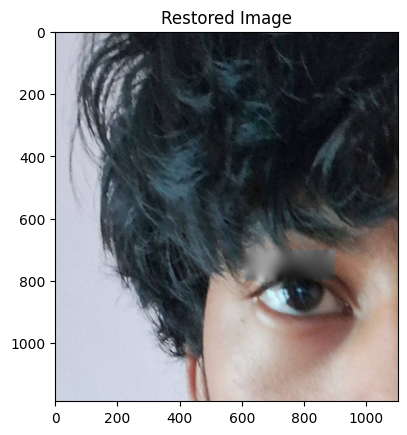

In [38]:
plt.title("Restored Image")
plt.imshow(restored_biharmonic)

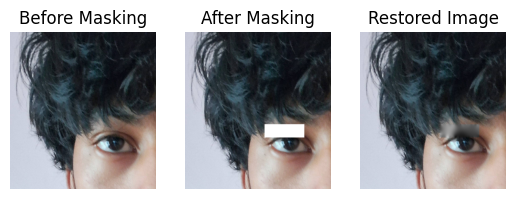

In [51]:
plt.subplot(1, 3, 1)
plt.title("Before Masking")
plt.axis("off")
plt.imshow(img)

plt.subplot(1, 3, 2)
plt.title("After Masking")
plt.axis("off")
plt.imshow(damaged_img)

plt.subplot(1, 3, 3)
plt.title("Restored Image")
plt.axis("off")
plt.imshow(restored_biharmonic)

plt.savefig("biharmonics.png", bbox_inches="tight")

In [83]:
def show_grid(img_title_pairs, size):
    rows, cols = size

    fig, axs = plt.subplots(rows, cols, figsize=(8, 8))

    if rows == 1 or cols == 1:
        for idx in range(rows * cols):
            axs[idx].imshow(img_title_pairs[idx][0])
            axs[idx].set_title(img_title_pairs[idx][1])
            axs[idx].axis("off")
    else:
        for r in range(rows):
            for c in range(cols):
                axs[r, c].imshow(img_title_pairs[r+c][0])
                axs[r, c].set_title(img_title_pairs[r+c][1])

    # return fig

In [84]:
imgs = [(img, "Before Masking"), (damaged_img, "After Masking"), (restored_biharmonic, "Restored Image")]

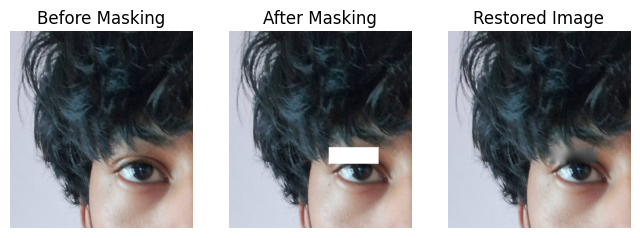

In [101]:
show_grid(imgs, (1, 3))
plt.savefig("Biharmonics-2.png", bbox_inches="tight")

## Image Segmentation

Image segmentation is the task of partitioning digital image into multiple segments based on the characteristics of pixels.

Segmentation can be supervised or unsupervised.

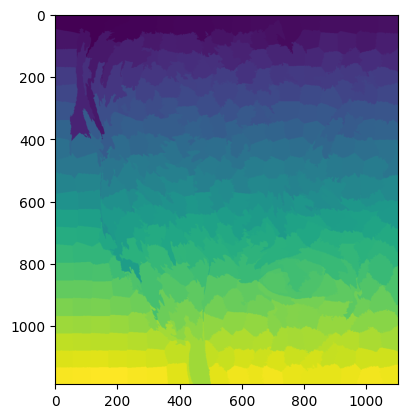

In [65]:
segments = slic(img, n_segments = 400)
plt.imshow(segments)

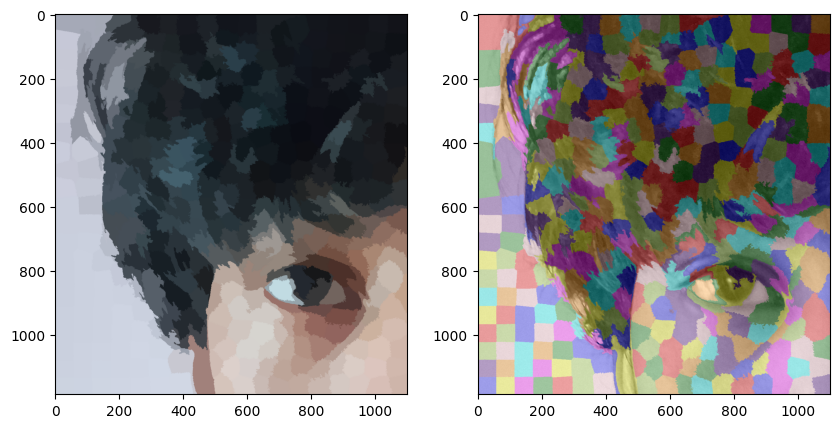

In [66]:
seg_avg_color = label2rgb(segments, img.numpy(), kind="avg")
seg_overlay_color = label2rgb(segments, img.numpy(), kind="overlay")

plt.figure(figsize = (10, 10))
plt.subplot(1, 2, 1)
plt.imshow(seg_avg_color)
plt.subplot(1, 2, 2)
plt.imshow(seg_overlay_color)

In [76]:
seg_imgs = [(img, "Image"), (seg_avg_color, "Average Segmentation"), (seg_overlay_color, "Overlay Segmentation")]

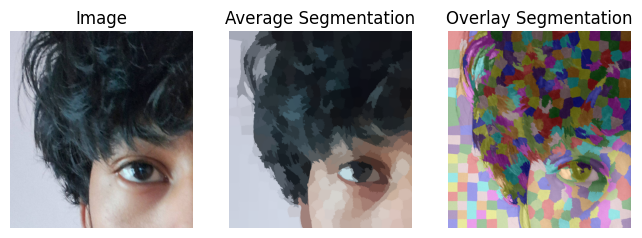

In [102]:
show_grid(seg_imgs, (1, 3))
plt.savefig("sef.png", bbox_inches="tight")


## Contours

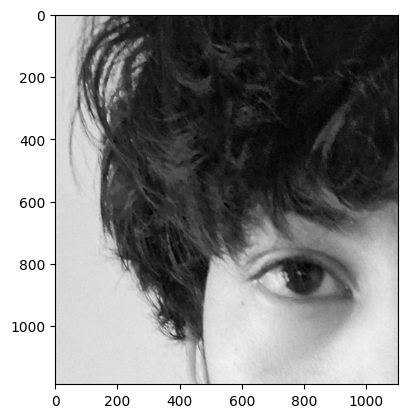

In [87]:
plt.imshow(img[:, :, 0], cmap="gray")

In [88]:
coin_contour = find_contours(img[:, :, 0].numpy(), 0.8)

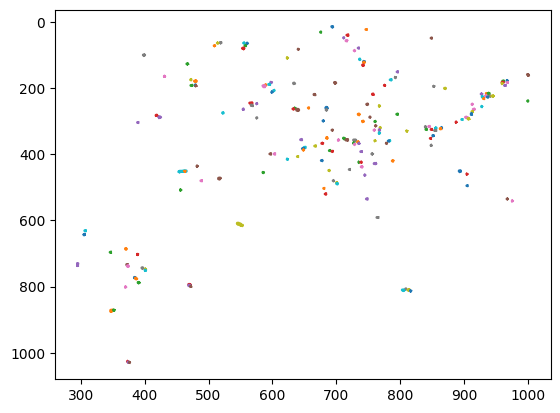

<Figure size 640x480 with 0 Axes>

In [103]:
for contour in coin_contour:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)

plt.gca().invert_yaxis()
plt.show()
plt.savefig("contour.png", bbox_inches="tight")


**Why did it come like this?**

## Edge and Corner Detection

### Canny Edge Detection

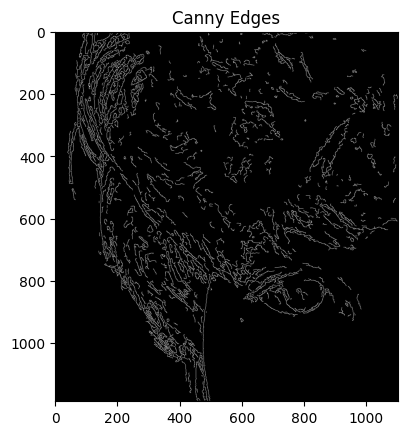

In [93]:
edges = canny(img[:, :, 0].numpy(), sigma=1)
plt.title("Canny Edges")
plt.imshow(edges, cmap="gray")

In [94]:
edge_imgs = [(img, "Image"), (edges, "Canny Edges")]

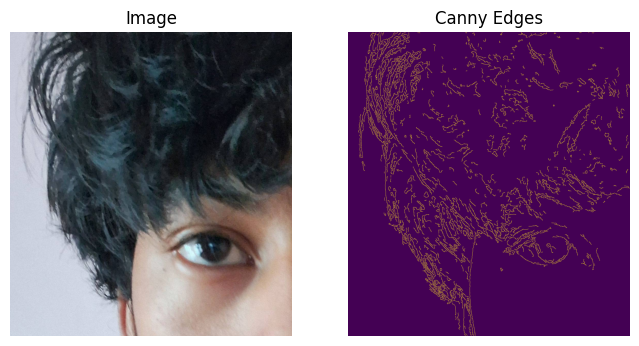

In [104]:
show_grid(edge_imgs, (1, 2))
plt.savefig("canny.png", bbox_inches="tight")


### Harris Corner Detector

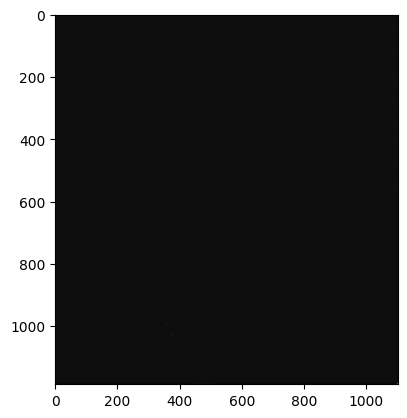

In [97]:
corner = corner_harris(img[:, :, 0], k=0.01, sigma=1)
plt.imshow(corner, cmap="gray")

In [98]:
corner_imgs = [(img, "image"), (corner, "Corners")]

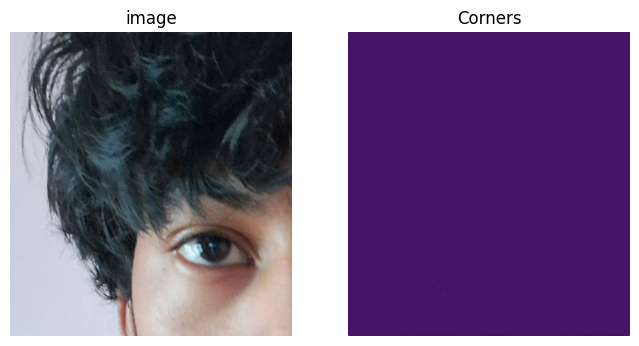

In [105]:
show_grid(corner_imgs, (1, 2))
plt.savefig("Harris.png", bbox_inches="tight")


**Why no edge detected?**

## Face Detection

In [3]:
roshan = io.decode_image("../assets/images/rt.jpg").permute(1, 2, 0)

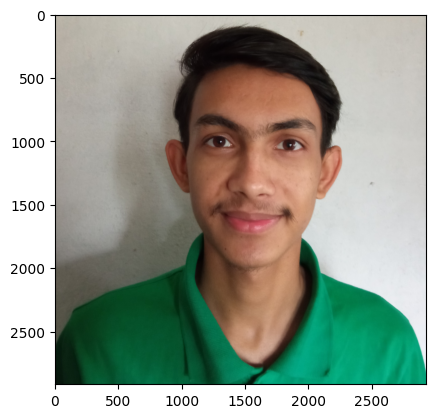

In [4]:
plt.imshow(roshan)

In [14]:
trained_file = skimage.data.lbp_frontal_face_cascade_filename()
detector = Cascade(trained_file)
detected_persons = detector.detect_multi_scale(img=roshan, scale_factor=1.1, step_ratio=1, min_size=(1000, 1000), max_size=(2000, 2000))

In [15]:
detected_persons

[{'r': 459, 'c': 850, 'width': 1463, 'height': 1463}]

In [27]:
roshan_copy = roshan.clone()
for patch in detected_persons:
    roshan_copy[patch["r"]:patch["r"]+patch["width"], patch["c"]-5:patch["c"]+5, :] = torch.tensor([255, 0, 0])
    roshan_copy[patch["r"]-5:patch["r"]+5, patch["c"]:patch["c"]+patch["height"], :] = torch.tensor([255, 0, 0])
    roshan_copy[(patch["r"]+patch["width"]-5):(patch["r"]+patch["width"]+5), patch["c"]:patch["c"]+patch["height"], :] = torch.tensor([255, 0, 0])
    roshan_copy[patch["r"]:patch["r"]+patch["width"], (patch["c"]+patch["height"]-5):(patch["c"]+patch["height"]+5), :] = torch.tensor([255, 0, 0])

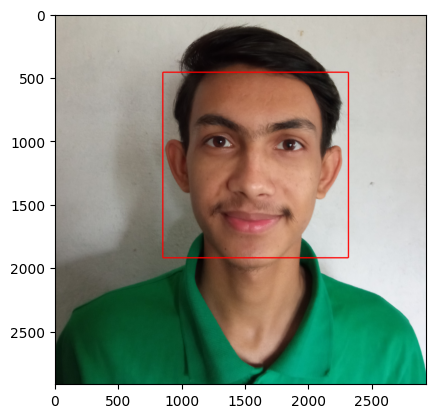

In [28]:
plt.imshow(roshan_copy)

In [100]:
det_imgs = [(roshan, "Image"), (roshan_copy, "Face Detection")]